<a href="https://colab.research.google.com/github/hugotorres22/data-analysis/blob/master/Spotipy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ideias:

New is always better (Heat map para ver se ando a ouvir musica que adicionei recentemente)

Divisão por estilos

Divisão por artistas

Horas ouvidas por dia

Horas mais frequentes a ouvir

Estilo mais predominante por hora

Caracteristicas da musica

In [ ]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 879 kB/s 
     |████████████████████████████████| 138 kB 46.7 MB/s 
     |████████████████████████████████| 244 kB 68.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import time
import numpy as np
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns 

In [ ]:
client_id = '005cbf60d85544348778d9b30a85fc67'
client_key = '45162ed0f7954b2f8339ca79dd233aa6'
playlist_id = '0hYPWa4VNYl1qkiMaPJHc0'
user_id = '1179099822'
scope = 'user-library-read'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_key,
                                               redirect_uri="http://192.168.2.34:8888",
                                               scope="user-library-read"))


#client_credentials_manager = SpotifyClientCredentials(client_id, client_key)
#sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager, scope='user-library-read')

In [ ]:
sp.me()

KeyboardInterrupt: ignored

In [ ]:
def get_tracks_id(tracks):
  
  track_ids = []
  
  for item in tracks:
    track_ids.append(item['track']['id'])

  return track_ids

In [ ]:
def get_playlist_tracks(user_id, playlist_id):
    results = sp.user_playlist_tracks(user_id, playlist_id)
    tracks = get_tracks_id(results['items'])
    while results['next']:
        results = sp.next(results)
        tracks.extend(get_tracks_id(results['items']))
    return tracks

In [ ]:
def get_all_tracks(user_id, playlist_id):

  play_list = sp.user_playlist_tracks(user_id, playlist_id)

  tracks = []

  for item in play_list['tracks']['items']:
    track = item['track']['id']
    tracks.append(track)
  
  return tracks

In [ ]:
def get_track_info(track):
  track_info = sp.track(track)

  name = track_info['name']
  artist_name = track_info['artists'][0]['name']
  artist_url = track_info['artists'][0]['external_urls']['spotify']
  album_name = track_info['album']['name']
  album_date = track_info['album']['release_date']
  album_popularity = track_info['popularity']
  track_duration = track_info['duration_ms']

  track_features = sp.audio_features(track)

  danceability = track_features[0]['danceability']
  energy = track_features[0]['energy']
  instrumentalness = track_features[0]['instrumentalness']
  liveness = track_features[0]['liveness']
  tempo = track_features[0]['tempo']

  track_complete_info = [name, artist_name, album_name, album_date, album_popularity, track_duration, danceability, energy, instrumentalness, liveness, tempo, artist_url]

  return track_complete_info

In [ ]:
def get_artist_genre(artist):

  genres = []

  for item in artists:
    genres.append(sp.artist(item)['genres'])

  return genres

In [ ]:
all_tracks = get_playlist_tracks(user_id, playlist_id)

track_info_list = []

for item in all_tracks:
  track_info_list.append(get_track_info(item))

df_tracks = pd.DataFrame(track_info_list, columns=['name', 'artist_name', 'album_name', 'album_date', 'album_popularity', 'track_duration', 'danceability', 'energy', 'instrumentalness', 'liveness', 'tempo','artist_url'])

In [ ]:
#df_tracks['album_year'] = pd.to_datetime(df_tracks['album_year'], format='%Y-%m-%d').dt.year
df_tracks['album_year'] = pd.to_datetime(df_tracks['album_date'], format='%Y-%m-%d').dt.year

In [ ]:
track_minutes = np.floor(df_tracks['track_duration']/1000/60).astype(int).astype(str)
track_seconds = np.mod(df_tracks['track_duration']/1000,60).astype(int).astype(str)
track_time = track_minutes.append(track_seconds).groupby(level=0).agg(':'.join)
df_tracks['track_duration'] = pd.to_datetime(track_time, format='%M:%S').dt.time

In [ ]:
df_tracks.tail()

,name,artist_name,album_name,album_date,album_popularity,track_duration,danceability,energy,instrumentalness,liveness,tempo,artist_url,album_year
1196,Unless It's Kicks,Okkervil River,The Stage Names,2007-08-07,44,00:04:38,0.362,0.828,0.000002,0.0877,123.664,https://open.spotify.com/artist/5E7zSu46SqTmgK...,2007
1197,Under the Rabbit,The Bronx,The Bronx (IV),2013-02-04,14,00:02:48,0.368,0.981,0.000053,0.3450,167.018,https://open.spotify.com/artist/7nqSDaZKccpnUq...,2013
1198,Take What You Want,Creature Canyon,Did You Want That,2018-10-19,19,00:03:36,0.515,0.935,0.000000,0.1130,148.034,https://open.spotify.com/artist/2dNInv9DAqXZhs...,2018
1199,Come Out and Play,The Offspring,Smash,1994-04-08,71,00:03:17,0.519,0.770,0.000003,0.0762,158.290,https://open.spotify.com/artist/5LfGQac0EIXyAN...,1994
1200,Twist,Naked Giants,R.I.P.,2016-10-14,38,00:03:33,0.261,0.859,0.000047,0.2890,172.866,https://open.spotify.com/artist/4KhnLZjONKS3nu...,2016


In [ ]:
artists = df_tracks['artist_url'].unique()
genres = get_artist_genre(artists)

In [ ]:
exploded_genres = pd.Series(genres, name='Genre').explode().reset_index()
text = ' '.join(str(i) for i in exploded_genres.Genre)

In [ ]:
wordcloud = WordCloud(background_color='White').generate(text)

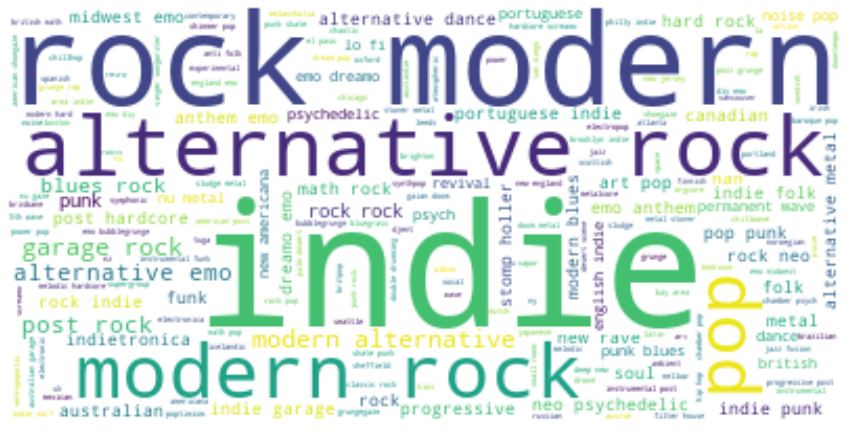

In [ ]:
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

HTTP Error for GET to https://api.spotify.com/v1/me/ with Params: {} returned 401 due to Unauthorized.


SpotifyException: ignored